In [111]:
# Cell 1: Imports and experiment configuration

import numpy as np
import pandas as pd
import yfinance as yf

from sklearn.preprocessing import StandardScaler


%matplotlib widget
import matplotlib.pyplot as plt

from utility import get_data, glasso

# Experiment configuration
TICKERS = pd.read_csv("tickers_names.csv")['Ticker'].tolist()
START_DATE = "2021-01-01"
END_DATE = "2024-01-01"

random_seed = 42
random_permutation = np.random.RandomState(seed=random_seed).permutation(len(TICKERS))[:50]
TICKERS = [TICKERS[i] for i in random_permutation]

ALPHA = 0.4                     # Graphical Lasso regularization parameter
WINDOW_WEEKS = 12
TRADING_DAYS_PER_WEEK = 5
WINDOW_SIZE = WINDOW_WEEKS * TRADING_DAYS_PER_WEEK  # approx 10 trading days

print("Config loaded.")
print("  n_tickers:", len(TICKERS))
print("  date range:", START_DATE, "->", END_DATE)
print("  WINDOW_SIZE (trading days):", WINDOW_SIZE)

Config loaded.
  n_tickers: 50
  date range: 2021-01-01 -> 2024-01-01
  WINDOW_SIZE (trading days): 60


In [112]:
# Retrieve daily returns
returns_df = get_data(TICKERS, START_DATE, END_DATE, min_coverage=0.95, fill_nan=False, save=False)

print("\nreturns_df info:")
print("  shape:", returns_df.shape)
print("  columns (tickers):", list(returns_df.columns))
print(returns_df.head())


[                       0%                       ]

[*********************100%***********************]  50 of 50 completed

Kept 46 / 50 tickers with >= 95% coverage
Dropped 148 days with missing data; 632 days remain
✅ Retrieved 46 assets over 632 days

returns_df info:
  shape: (632, 46)
  columns (tickers): ['A', 'ACGL', 'ADSK', 'AEM', 'AFL', 'AI.PA', 'ATO', 'AV.L', 'BA', 'CA.PA', 'CLX', 'CMI', 'CNP', 'D', 'DB1.DE', 'DD', 'EBS.VI', 'ETR', 'FRE.DE', 'FTS.TO', 'GLE.PA', 'GTN.BE', 'HEI.DE', 'HMC', 'IAG.TO', 'IDXX', 'KER.PA', 'KIR.MU', 'LAND.L', 'LOGI', 'MO', 'MSTR', 'NTRS', 'O39.SI', 'PHIA.AS', 'QBR-B.TO', 'SGSLX', 'SHEL', 'STE', 'SU.PA', 'TJX', 'UBS', 'UDR', 'VMC', 'VRTX', 'WPP']
Ticker             A      ACGL      ADSK       AEM       AFL     AI.PA  \
Date                                                                     
2021-01-05  0.008176  0.004011  0.016373 -0.012503  0.001621 -0.010627   
2021-01-06  0.027423  0.043950  0.003878  0.017241  0.038604  0.002222   
2021-01-07  0.026609 -0.009295  0.040711  0.011520 -0.005564  0.007760   
2021-01-08  0.007134  0.005519  0.014753 -0.055897 -0.004252  0.

In [113]:
# Cell 3: Split the returns into fixed windows

def split_into_windows(returns_df, window_size):
    """
    Split the returns DataFrame into non-overlapping windows
    of length `window_size` along the time axis.
    """
    n_samples = returns_df.shape[0]
    n_windows = n_samples // window_size  # floor division

    windows = []
    for i in range(n_windows):
        start = i * window_size
        end = start + window_size
        win = returns_df.iloc[start:end]
        windows.append(win)
    return windows

windows = split_into_windows(returns_df, WINDOW_SIZE)

print("Number of windows:", len(windows))
if len(windows) > 0:
    print("First window shape:", windows[0].shape)
    print("First window date range:", windows[0].index[0].date(), "->", windows[0].index[-1].date())
    print("Last window date range:", windows[-1].index[0].date(), "->", windows[-1].index[-1].date())


Number of windows: 10
First window shape: (60, 46)
First window date range: 2021-01-05 -> 2021-04-08
Last window date range: 2023-07-27 -> 2023-11-06


Sample Var. conditioning: 30522.482483271247
 Glasso Var. conditioning: 4527.528232570148
Sample Var. conditioning: 325881.8964773301
 Glasso Var. conditioning: 50484.09630504664
Sample Var. conditioning: 7560.421368230447
 Glasso Var. conditioning: 1209.4969763923511
Sample Var. conditioning: 4170.453624330399
 Glasso Var. conditioning: 722.5402921641312
Sample Var. conditioning: 13954.225424592036
 Glasso Var. conditioning: 447.42570249666187
Sample Var. conditioning: 27990.38587213057
 Glasso Var. conditioning: 1910.2853573768434
Sample Var. conditioning: 28909.834165009986
 Glasso Var. conditioning: 1041.5665788103975
Sample Var. conditioning: 5260.83201714283
 Glasso Var. conditioning: 115.6803386128811
Sample Var. conditioning: 3101.8523971470763
 Glasso Var. conditioning: 76.78022445808853
Sample Var. conditioning: 1550.8477591743733
 Glasso Var. conditioning: 57.54175840859737
Covariance and precision matrices computed.
  number of windows: 10
  covariance matrix shape: (46, 46

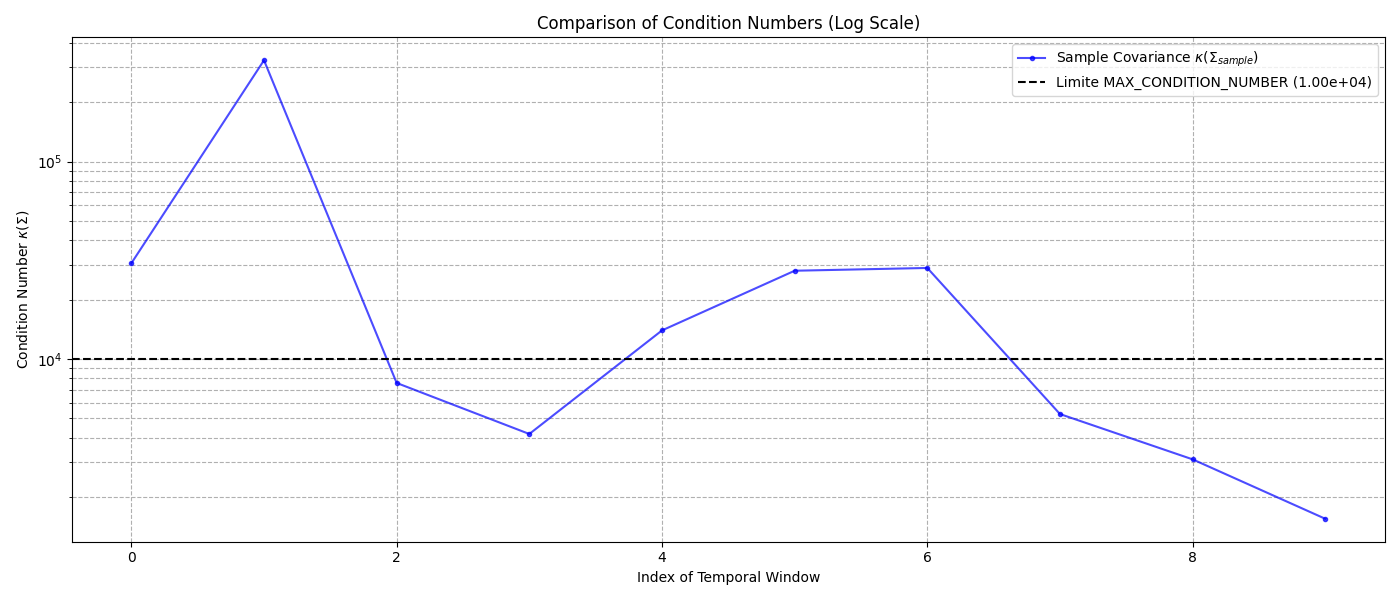


--- Analisi Dettagliata del Condizionamento ---
Limite MAX_CONDITION_NUMBER utilizzato: 1.00e+04
Numero totale di finestre: 10
----------------------------------------
Finestre mal condizionate (Campione): 5 (50.00%)


In [114]:
# Cell 4: Covariance and precision estimation per window (sample and Glasso)
# Adds a condition-number check before attempting to invert the sample covariance.

MAX_CONDITION_NUMBER = 1e4  # threshold to consider a matrix "well-conditioned"


def compute_cov_prec_for_window(window_returns, alpha):
    """
    Given a returns window (T x N), standardize it, then:
    - compute the sample covariance of standardized data
    - compute the inverse (precision) of the sample covariance, but only if it is
      sufficiently well-conditioned (based on the condition number)
    - compute a Ledoit–Wolf covariance for input to Graphical Lasso
    - apply Graphical Lasso to obtain a regularized covariance + precision

    Returns
    -------
    sample_cov : (N, N) ndarray
        Sample covariance matrix of standardized returns.
    sample_prec : (N, N) ndarray or None
        Inverse (precision) of sample_cov. Uses pseudo-inverse if poorly conditioned,
        or None if even pseudo-inverse fails.
    glasso_cov : (N, N) ndarray
        Covariance matrix estimated by Graphical Lasso.
    glasso_prec : (N, N) ndarray
        Precision matrix estimated by Graphical Lasso.
    """
    # --- STANDARDIZE RETURNS IN THE WINDOW ---
    scaler = StandardScaler()
    X = scaler.fit_transform(window_returns.values)  # shape: (T, N)

    # --- UNREGULARIZED SAMPLE COVARIANCE ---
    sample_cov = np.cov(X, rowvar=False)  # shape: (N, N)
    s = scaler.scale_
    D = np.diag(s)
    sample_cov = D @ sample_cov @ D

    # --- CONDITION NUMBER CHECK ---
    try:
        cond_sample = np.linalg.cond(sample_cov) # 2-norm, computed directly using the SVD
    except np.linalg.LinAlgError as e:
        print(
            "Warning: could not compute condition number for sample covariance "
            f"in this window. Treating it as ill-conditioned.\n  Details: {e}"
        )
        cond_sample = np.inf

    sample_prec = None
    
    try:
        sample_prec = np.linalg.inv(sample_cov)
    except np.linalg.LinAlgError as e:
        print(
            "Warning:"
            f"(cond={cond_sample:.2e}) and inversion failed;\n"
            f"  Details: {e}"
        )
        sample_prec = None

    # --- GLASSO --- 
    glasso_cov, glasso_prec = glasso(alpha=alpha, returns_df=window_returns, save_outputs=False, max_iter=100)
        
    cond_glasso = np.linalg.cond(glasso_cov)
    
    print(f"Sample Var. conditioning: {cond_sample}\n Glasso Var. conditioning: {cond_glasso}")

    return sample_cov, cond_sample, sample_prec, glasso_cov, cond_glasso, glasso_prec


# Run estimation on all windows
sample_covs = []
sample_precs = []   # list of sample precision matrices (or None)
cond_sample = []
glasso_covs = []
glasso_precs = []   # list of Glasso precision matrices
cond_glasso = []

for idx, win in enumerate(windows):
    s_cov, s_cond, s_prec, g_cov, g_cond, g_prec = compute_cov_prec_for_window(win, ALPHA)
    sample_covs.append(s_cov)
    cond_sample.append(s_cond)
    sample_precs.append(s_prec)
    glasso_covs.append(g_cov)
    cond_glasso.append(g_cond)
    glasso_precs.append(g_prec)

print("Covariance and precision matrices computed.")
print("  number of windows:", len(sample_covs))
if len(sample_covs) > 0:
    print("  covariance matrix shape:", sample_covs[0].shape)
    

# --- 2. Funzione di Plotting e Analisi ---

window_indices = np.arange(len(cond_sample))

plt.figure(figsize=(14, 6))

# Plot dei valori di condizionamento campionari
plt.plot(window_indices, cond_sample, label='Sample Covariance $\\kappa(\\Sigma_{sample})$', marker='.', linestyle='-', color='blue', alpha=0.7)

# Plot dei valori di condizionamento Glasso - not very useful since we do not invert it
# plt.plot(window_indices, cond_glasso, label='Graphical Lasso Covariance $\\kappa(\\Sigma_{Glasso})$', marker='.', linestyle='-', color='red', alpha=0.7)

# Linea orizzontale per il limite di mal condizionamento
plt.axhline(MAX_CONDITION_NUMBER, color='k', linestyle='--', label=f'Limite MAX_CONDITION_NUMBER ({MAX_CONDITION_NUMBER:.2e})')

# Impostazioni del grafico
plt.yscale('log') # Usa una scala logaritmica per vedere i grandi valori
plt.title('Comparison of Condition Numbers (Log Scale)')
plt.xlabel('Index of Temporal Window')
plt.ylabel('Condition Number $\\kappa(\\Sigma)$')
plt.legend()
plt.grid(True, which="both", ls="--")
plt.tight_layout()
plt.show()

# --- 3. Analisi del Condizionamento ---

# Controlla per i valori mal condizionati (condizionamento > Limite)
num_windows = len(window_indices)
num_sample_ill = np.sum(np.array(cond_sample) > MAX_CONDITION_NUMBER)
# num_glasso_ill = np.sum(np.array(cond_glasso) > MAX_CONDITION_NUMBER)

print("\n--- Analisi Dettagliata del Condizionamento ---")
print(f"Limite MAX_CONDITION_NUMBER utilizzato: {MAX_CONDITION_NUMBER:.2e}")
print(f"Numero totale di finestre: {num_windows}")
print("-" * 40)
print(f"Finestre mal condizionate (Campione): {num_sample_ill} ({num_sample_ill / num_windows * 100:.2f}%)")
# print(f"Finestre mal condizionate (Glasso): {num_glasso_ill} ({num_glasso_ill / num_windows * 100:.2f}%)")


In [115]:
# Cell 5: Frobenius norm differences across consecutive windows

def frobenius_differences(cov_list):
    """
    Compute 
      norm of differences between consecutive
    covariance matrices in `cov_list`.
    """
    diffs = []
    for i in range(len(cov_list) - 1):
        delta = (cov_list[i+1] - cov_list[i])
        frob = np.linalg.norm(delta, ord='fro')/(np.linalg.norm(cov_list[i], ord='fro')) #+ np.linalg.norm(cov_list[i], ord='fro'))  # NORMALIZATION
        diffs.append(frob)
    return np.array(diffs)

fro_sample = frobenius_differences(sample_covs)
fro_glasso = frobenius_differences(glasso_covs)

# Build a DataFrame for easier inspection
window_pairs = []
for i in range(len(windows) - 1):
    w1 = windows[i]
    w2 = windows[i+1]
    label = f"{w1.index[0].date()}–{w1.index[-1].date()} -> {w2.index[0].date()}–{w2.index[-1].date()}"
    window_pairs.append(label)

results_df = pd.DataFrame({
    "window_pair": window_pairs,
    "frobenius_sample": fro_sample,
    "frobenius_glasso": fro_glasso,
})

print("Frobenius differences between consecutive windows:")
print(results_df.head())
print("\nSummary statistics:")
print("  mean(sample) :", results_df["frobenius_sample"].mean())
print("  mean(glasso) :", results_df["frobenius_glasso"].mean())
print("  std(sample)  :", results_df["frobenius_sample"].std())
print("  std(glasso)  :", results_df["frobenius_glasso"].std())


Frobenius differences between consecutive windows:
                                      window_pair  frobenius_sample  \
0  2021-01-05–2021-04-08 -> 2021-04-09–2021-07-23          6.888437   
1  2021-04-09–2021-07-23 -> 2021-07-26–2021-11-02          0.997904   
2  2021-07-26–2021-11-02 -> 2021-11-03–2022-02-16          0.848588   
3  2021-11-03–2022-02-16 -> 2022-02-17–2022-05-27          1.965883   
4  2022-02-17–2022-05-27 -> 2022-06-01–2022-09-21          4.274936   

   frobenius_glasso  
0          7.938334  
1          0.998071  
2          0.495586  
3          1.351932  
4          7.659174  

Summary statistics:
  mean(sample) : 1.9616003443455716
  mean(glasso) : 2.2907170143445037
  std(sample)  : 2.2004489251874277
  std(glasso)  : 3.142874168395557


In [116]:
# Cell 6: Plot sample vs Glasso Frobenius norms
# Not very informative, because we do not need to invert the covarinace matrix when using glasso.

# plt.figure(figsize=(10, 6))
# x = np.arange(1, len(fro_sample) + 1)

# plt.plot(x, fro_sample, marker='o', label="Sample covariance")
# plt.plot(x, fro_glasso, marker='o', label="Graphical Lasso covariance")

# plt.xlabel("Consecutive window index (i → i+1)")
# plt.ylabel("Normalized Frobenius norm of ΔΣ")
# plt.title(f"Stability of covariance estimates across {WINDOW_WEEKS}-week windows")
# plt.grid(True)
# plt.legend()
# plt.tight_layout()
# plt.show()

# print("Stability comparison plot generated.")


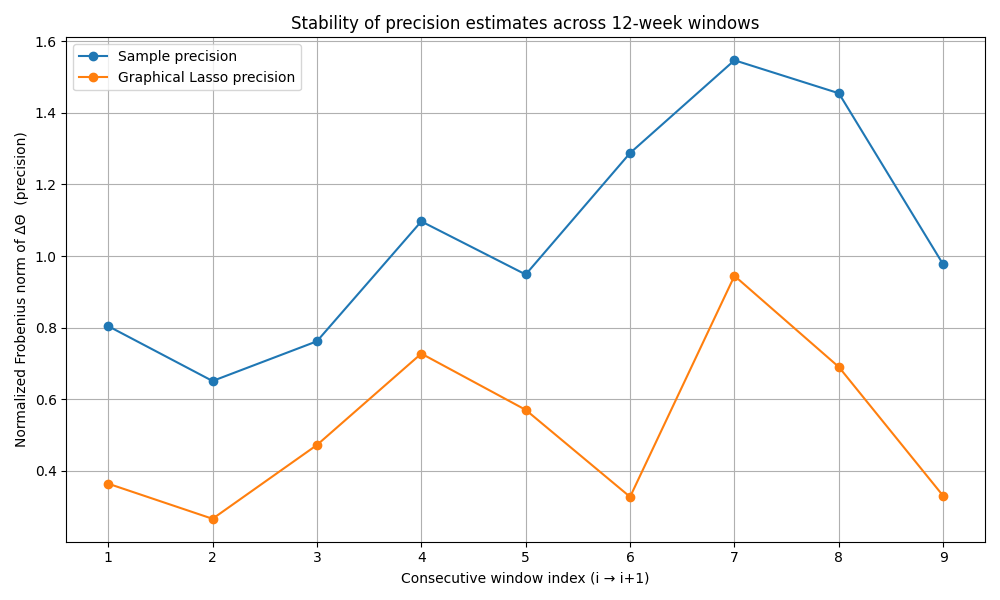

Frobenius differences between consecutive windows (PRECISION matrices):
  window_pair  frobenius_sample_prec  frobenius_glasso_prec
0         0→1               0.804338               0.364436
1         1→2               0.651076               0.266343
2         2→3               0.761963               0.472329
3         3→4               1.096682               0.727543
4         4→5               0.948416               0.570464

Summary statistics for precision matrices:
  mean(sample precision) : 1.0585868386041584
  mean(glasso precision) : 0.5214999557657608
  std(sample precision)  : 0.31349402075759003
  std(glasso precision)  : 0.22878782237127931
Precision stability comparison plot generated.
[0.80433765 0.65107604 0.76196264 1.09668243 0.94841594 1.28756899
 1.54653988 1.45437383 0.97632415]
[0.36443598 0.26634256 0.47232911 0.72754295 0.57046361 0.32757454
 0.9446163  0.69011543 0.33007912]


In [117]:
# Cell 7: Frobenius norm differences for precision matrices (sample vs Glasso)

# Reuse the same helper; it works for any list of matrices (covariances or precisions)
if any(prec is None for prec in sample_precs):
    print("Warning: Some sample precision matrices are None; Frobenius differences may be affected.")
else:
    fro_sample_prec = frobenius_differences(sample_precs)
    fro_glasso_prec = frobenius_differences(glasso_precs)

    # Label window pairs i -> i+1
    window_pairs_prec = [f"{i}→{i+1}" for i in range(len(fro_sample_prec))]

    prec_results_df = pd.DataFrame({
        "window_pair": window_pairs_prec,
        "frobenius_sample_prec": fro_sample_prec,
        "frobenius_glasso_prec": fro_glasso_prec,
    })
    # Plot the stability over window pairs
    plt.figure(figsize=(10, 6))
    x = np.arange(1, len(fro_sample_prec) + 1)

    plt.plot(x, fro_sample_prec, marker='o', label="Sample precision")
    plt.plot(x, fro_glasso_prec, marker='o', label="Graphical Lasso precision")

    plt.xlabel("Consecutive window index (i → i+1)")
    plt.ylabel("Normalized Frobenius norm of ΔΘ  (precision)")
    plt.title(f"Stability of precision estimates across {WINDOW_WEEKS}-week windows")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

    print("Frobenius differences between consecutive windows (PRECISION matrices):")
    print(prec_results_df.head())

    print("\nSummary statistics for precision matrices:")
    print("  mean(sample precision) :", prec_results_df["frobenius_sample_prec"].mean())
    print("  mean(glasso precision) :", prec_results_df["frobenius_glasso_prec"].mean())
    print("  std(sample precision)  :", prec_results_df["frobenius_sample_prec"].std())
    print("  std(glasso precision)  :", prec_results_df["frobenius_glasso_prec"].std())

    print("Precision stability comparison plot generated.")


    print(fro_sample_prec)
    print(fro_glasso_prec)


Computing GMV (Markowitz min-var) portfolios and evaluating on next window...
Window 0->1: cumret Sample=-0.1016, Glasso=-0.0577 | lev Sample=1.77, Glasso=1.00
Window 4->5: cumret Sample=-0.2129, Glasso=-0.1419 | lev Sample=3.71, Glasso=1.00


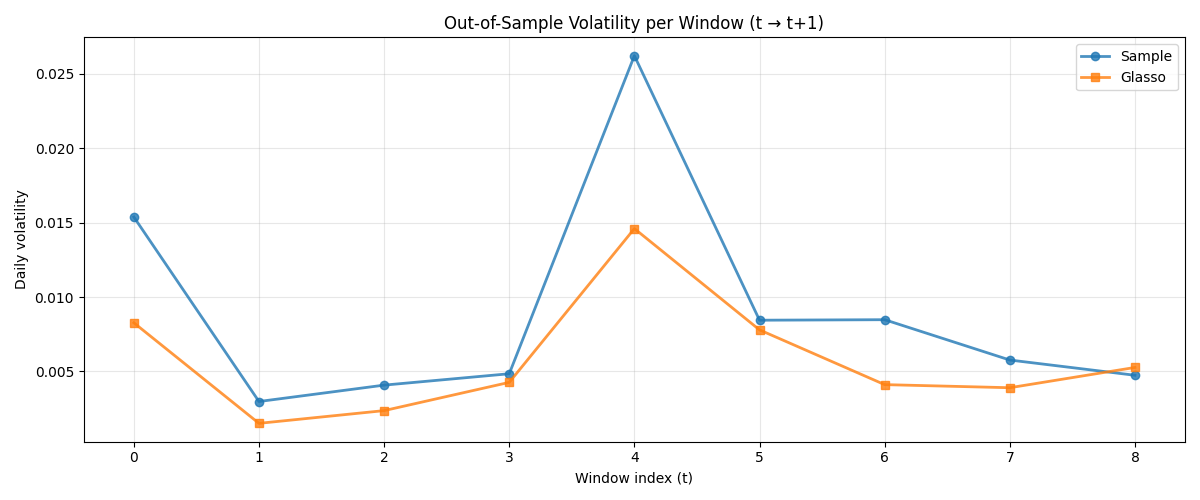

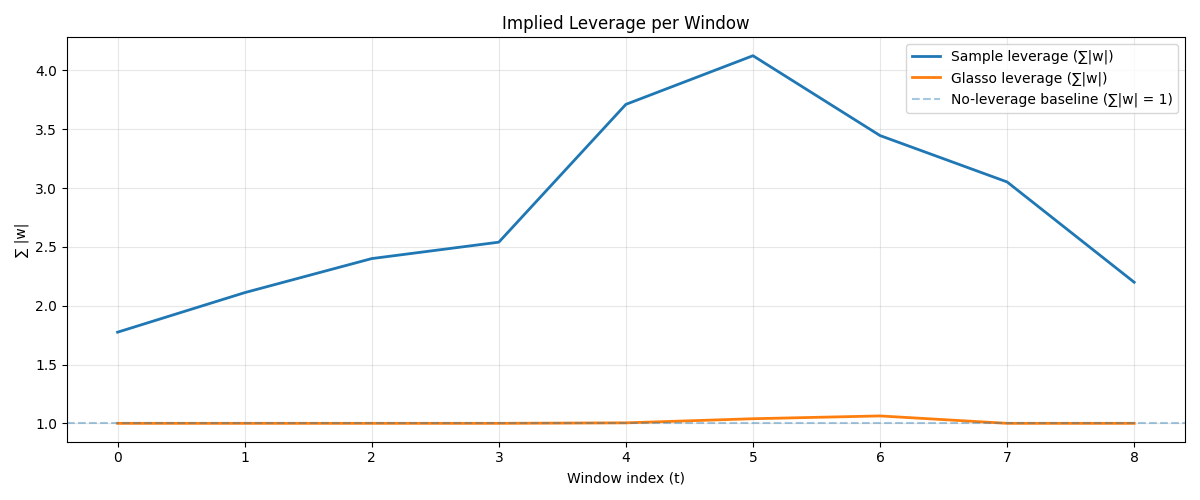

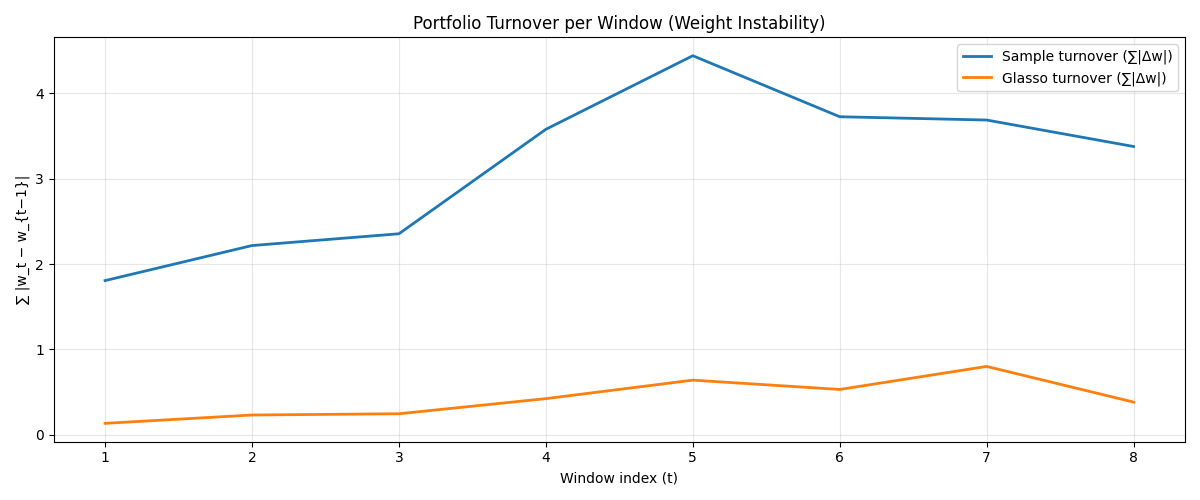

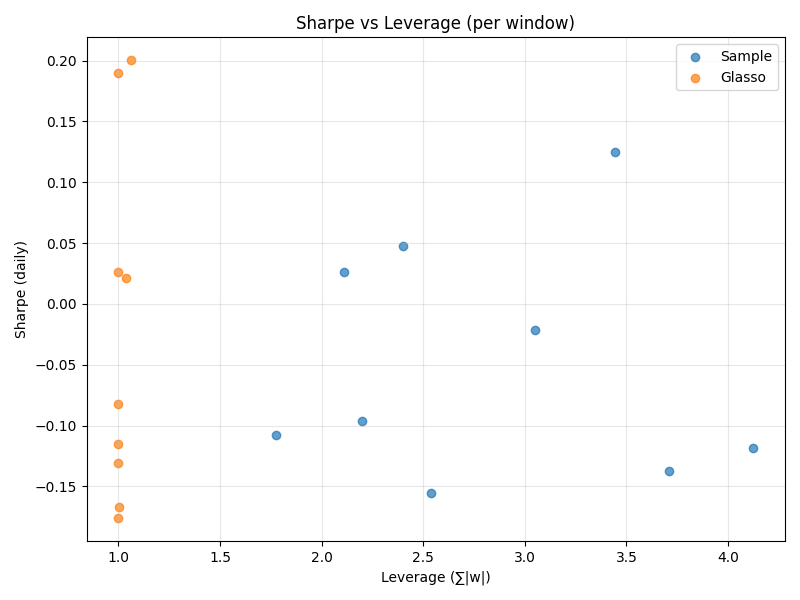

✅ Final diagnostic plots generated: volatility, leverage, turnover, Sharpe-vs-leverage.


In [118]:
# ============================================================
# FINAL DIAGNOSTIC PLOTS — ONLY WHAT MATTERS
# Focus: risk control, stability, unnecessary leverage
# ============================================================

import matplotlib.pyplot as plt

def min_variance_portfolio(Theta):
    """
    Global Minimum Variance portfolio under 1'w = 1, short-selling allowed.
    Uses only the precision matrix Theta = Sigma^{-1}.
    
    w* = Theta 1 / (1' Theta 1)
    """
    ones = np.ones(Theta.shape[0])
    A = ones @ Theta @ ones
    if A <= 0 or not np.isfinite(A):
        raise ValueError("Invalid A = 1' Theta 1. Precision matrix may be invalid.")
    w_mv = (Theta @ ones) / A
    return w_mv


def portfolio_returns(w, returns_df):
    """
    Compute portfolio daily returns for each day in returns_df (T x N).
    r_p = R @ w
    """
    if isinstance(returns_df, pd.DataFrame):
        if isinstance(w, pd.Series):
            w_aligned = w.reindex(returns_df.columns, fill_value=0.0).values
        else:
            w_aligned = np.asarray(w)
        return (returns_df.values @ w_aligned).flatten()
    else:
        return (np.asarray(returns_df) @ np.asarray(w)).flatten()

def get_sample_precision(t):
    """
    Return a usable precision matrix for the sample estimator at window t.
    If precomputed inverse is missing (None), fall back to pseudo-inverse of sample covariance.
    """
    prec = sample_precs[t]
    if prec is None:
        cov = sample_covs[t]
        prec = np.linalg.pinv(cov)
    return prec

# -----------------------------
# Storage for results
# -----------------------------
results = {
    "window_idx": [],

    # Out-of-sample performance on window t+1
    "sample_cumulative_return": [],
    "glasso_cumulative_return": [],
    "sample_sharpe": [],
    "glasso_sharpe": [],
    "sample_volatility": [],
    "glasso_volatility": [],
    "sample_mean_return": [],
    "glasso_mean_return": [],

    # Diagnostics (risk / instability)
    "sample_leverage_L1": [],     # sum |w|
    "glasso_leverage_L1": [],
    "sample_turnover_L1": [],     # sum |w_t - w_{t-1}|
    "glasso_turnover_L1": [],
}

print("Computing GMV (Markowitz min-var) portfolios and evaluating on next window...")
print("=" * 70)

# We'll keep previous weights to compute turnover
prev_w_sample = None
prev_w_glasso = None

# Iterate over windows (skip last window as there's no t+1)
for t in range(len(windows) - 1):
    window_t = windows[t]
    window_t1 = windows[t + 1]

    # Ensure same asset universe in t and t+1
    if not window_t.columns.equals(window_t1.columns):
        print(f"Warning: Window {t} and {t+1} have different assets. Skipping (would need recompute covariances).")
        continue

    # Get precision matrices for window t
    try:
        sample_prec_t = get_sample_precision(t)
        glasso_prec_t = glasso_precs[t]
    except Exception as e:
        print(f"Window {t}: could not retrieve precision matrices: {e}. Skipping.")
        continue

    # Compute GMV weights
    try:
        w_sample = min_variance_portfolio(sample_prec_t)
        w_glasso = min_variance_portfolio(glasso_prec_t)
    except Exception as e:
        print(f"Window {t}: error computing GMV weights: {e}. Skipping.")
        continue

    # Diagnostics: leverage (sum|w|)
    lev_sample = float(np.sum(np.abs(w_sample)))
    lev_glasso = float(np.sum(np.abs(w_glasso)))

    # Diagnostics: turnover (sum|Δw|)
    if prev_w_sample is None:
        to_sample = np.nan
        to_glasso = np.nan
    else:
        to_sample = float(np.sum(np.abs(w_sample - prev_w_sample)))
        to_glasso = float(np.sum(np.abs(w_glasso - prev_w_glasso)))

    # Apply weights to window t+1 returns (out-of-sample)
    w_sample_series = pd.Series(w_sample, index=window_t.columns)
    w_glasso_series = pd.Series(w_glasso, index=window_t.columns)

    portfolio_ret_sample = portfolio_returns(w_sample_series, window_t1)
    portfolio_ret_glasso = portfolio_returns(w_glasso_series, window_t1)

    # Performance metrics (daily)
    cumret_sample = float(np.prod(1.0 + portfolio_ret_sample) - 1.0)
    cumret_glasso = float(np.prod(1.0 + portfolio_ret_glasso) - 1.0)

    meanret_sample = float(np.mean(portfolio_ret_sample))
    meanret_glasso = float(np.mean(portfolio_ret_glasso))

    # Use ddof=1 for sample std (more standard); keep ddof=0 if you prefer
    vol_sample = float(np.std(portfolio_ret_sample, ddof=1))
    vol_glasso = float(np.std(portfolio_ret_glasso, ddof=1))

    # Sharpe (daily), rf=0
    sharpe_sample = (meanret_sample / vol_sample) if vol_sample > 1e-12 else 0.0
    sharpe_glasso = (meanret_glasso / vol_glasso) if vol_glasso > 1e-12 else 0.0

    # Store results
    results["window_idx"].append(t)

    results["sample_cumulative_return"].append(cumret_sample)
    results["glasso_cumulative_return"].append(cumret_glasso)

    results["sample_sharpe"].append(sharpe_sample)
    results["glasso_sharpe"].append(sharpe_glasso)

    results["sample_volatility"].append(vol_sample)
    results["glasso_volatility"].append(vol_glasso)

    results["sample_mean_return"].append(meanret_sample)
    results["glasso_mean_return"].append(meanret_glasso)

    results["sample_leverage_L1"].append(lev_sample)
    results["glasso_leverage_L1"].append(lev_glasso)

    results["sample_turnover_L1"].append(to_sample)
    results["glasso_turnover_L1"].append(to_glasso)

    # Update previous weights
    prev_w_sample = w_sample
    prev_w_glasso = w_glasso

    if (t + 1) % 5 == 0 or t == 0:
        print(f"Window {t}->{t+1}: cumret Sample={cumret_sample:.4f}, Glasso={cumret_glasso:.4f} | "
              f"lev Sample={lev_sample:.2f}, Glasso={lev_glasso:.2f}")

# Convert to DataFrame
results_df = pd.DataFrame(results)

x = results_df["window_idx"]

# -----------------------------
# 1. OOS Volatility per window
# (optional but very informative)
# -----------------------------
plt.figure(figsize=(12, 5))
plt.plot(
    x, results_df["sample_volatility"],
    marker="o", linewidth=2, label="Sample", alpha=0.8
)
plt.plot(
    x, results_df["glasso_volatility"],
    marker="s", linewidth=2, label="Glasso", alpha=0.8
)
plt.title("Out-of-Sample Volatility per Window (t → t+1)")
plt.xlabel("Window index (t)")
plt.ylabel("Daily volatility")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# -----------------------------
# 2. Implied Leverage (CORE)
# -----------------------------
plt.figure(figsize=(12, 5))
plt.plot(
    x, results_df["sample_leverage_L1"],
    linewidth=2, label="Sample leverage (∑|w|)"
)
plt.plot(
    x, results_df["glasso_leverage_L1"],
    linewidth=2, label="Glasso leverage (∑|w|)"
)
plt.axhline(
    1.0, linestyle="--", alpha=0.4,
    label="No-leverage baseline (∑|w| = 1)"
)
plt.title("Implied Leverage per Window")
plt.xlabel("Window index (t)")
plt.ylabel("∑ |w|")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# -----------------------------
# 3. Turnover (CORE)
# -----------------------------
plt.figure(figsize=(12, 5))
plt.plot(
    x, results_df["sample_turnover_L1"],
    linewidth=2, label="Sample turnover (∑|Δw|)"
)
plt.plot(
    x, results_df["glasso_turnover_L1"],
    linewidth=2, label="Glasso turnover (∑|Δw|)"
)
plt.title("Portfolio Turnover per Window (Weight Instability)")
plt.xlabel("Window index (t)")
plt.ylabel("∑ |w_t − w_{t−1}|")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# -----------------------------
# 4. Sharpe vs Leverage (support)
# -----------------------------
df_scatter = results_df.dropna(subset=[
    "sample_leverage_L1", "glasso_leverage_L1",
    "sample_sharpe", "glasso_sharpe"
])

plt.figure(figsize=(8, 6))
plt.scatter(
    df_scatter["sample_leverage_L1"],
    df_scatter["sample_sharpe"],
    alpha=0.7, label="Sample"
)
plt.scatter(
    df_scatter["glasso_leverage_L1"],
    df_scatter["glasso_sharpe"],
    alpha=0.7, label="Glasso"
)
plt.xlabel("Leverage (∑|w|)")
plt.ylabel("Sharpe (daily)")
plt.title("Sharpe vs Leverage (per window)")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

print("✅ Final diagnostic plots generated: volatility, leverage, turnover, Sharpe-vs-leverage.")


# 📊 Markowitz GMV with Sample vs Graphical Lasso  
### Stability, Risk Diagnostics, and Out-of-Sample Behavior

This notebook compares **two estimators of the covariance / precision matrix** in a **Global Minimum Variance (GMV) Markowitz portfolio** framework:

* **Sample covariance** (and its inverse / pseudo-inverse)
* **Graphical Lasso (Glasso)** covariance and precision

The goal is **not** to maximize returns, but to study **stability, numerical robustness, and economically meaningful risk diagnostics** in a high-dimensional setting.

---

## 🧠 Context: Why This Experiment Matters

In realistic financial problems we often have:
* **Many assets ($N$ large)**
* **Few observations per window ($T$ small)** This leads to:
* Ill-conditioned or singular sample covariance matrices.
* Extremely unstable portfolio weights.
* Large estimation error amplified by matrix inversion.

Regularization methods like **Graphical Lasso** are designed to address these issues by promoting sparsity in the precision matrix.

---

## 📐 Global Minimum Variance (GMV) Portfolio

We focus on the **GMV portfolio**, defined as:

$$\min_w \; w^\top \Sigma w \quad \text{s.t. } \mathbf{1}^\top w = 1$$

Its closed-form solution depends **only on the precision matrix**:

$$w^* = \frac{\Theta \mathbf{1}}{\mathbf{1}^\top \Theta \mathbf{1}}, \quad \Theta = \Sigma^{-1}$$

This makes GMV an ideal testbed to compare covariance estimators:
* Any instability in $\Theta$ directly translates into unstable weights.

---

## 🔁 Rolling Windows and Out-of-Sample Evaluation

For each rolling window $t$:

1. Estimate covariance / precision using data in window $t$.
2. Compute GMV weights using that estimate.
3. Apply the weights to **returns in window $t+1$** (out-of-sample).
4. Measure performance and stability diagnostics.

This avoids in-sample bias and reveals how estimation error propagates forward.

---

## 📊 Quantities We Compute and Why They Matter

### 1️⃣ Cumulative Return (Out-of-Sample)

$$\prod_{i \in t+1} (1 + r_{p,i}) - 1$$

* Measures realized performance using weights estimated at time $t$.
* Not the main objective here, but useful as a sanity check.

---

### 2️⃣ Mean Return and Volatility

* **Mean daily return**: average performance in window $t+1$.
* **Volatility**: standard deviation of daily portfolio returns.

Used mainly to compute the Sharpe ratio.

---

### 3️⃣ Sharpe Ratio (Daily, $rf = 0$)

$$\text{Sharpe} = \frac{\mathbb{E}[r_p]}{\sigma_p}$$

* A risk-adjusted performance metric.
* In this experiment, Sharpe is **secondary** to stability diagnostics.
* GMV portfolios are not designed to maximize Sharpe.

---

## ⚠️ Stability and "Unnecessary Risk" Diagnostics

These are the **most important quantities** in this notebook.

### 4️⃣ Leverage (L1 Norm of Weights)

$$\text{Leverage} = \sum_i |w_i|$$

**Interpretation:**
* $= 1$: no leverage (long-only baseline).
* $> 1$: implicit leverage via long–short positions.
* Very large values indicate **extreme and fragile portfolios**.

**Expectation:**
* Sample covariance $\rightarrow$ very high leverage.
* Glasso $\rightarrow$ significantly lower and more stable leverage.

---

### 5️⃣ Turnover (Weight Instability)

$$\text{Turnover}_t = \sum_i |w_{t,i} - w_{t-1,i}|$$

**Interpretation:**
* Measures how much the portfolio changes between windows.
* Proxy for transaction costs and model instability.

**Expectation:**
* Sample GMV $\rightarrow$ large, erratic turnover.
* Glasso GMV $\rightarrow$ smoother weight evolution.

---

## 🔢 Frobenius Norm Differences

We also compute:

$$\frac{\|\Sigma_{t+1} - \Sigma_t\|_F}{\|\Sigma_t\|_F} \quad \text{and} \quad \frac{\|\Theta_{t+1} - \Theta_t\|_F}{\|\Theta_t\|_F}$$

**Purpose:**
* Quantify how sensitive covariance and precision estimates are to small data changes.
* Connect numerical conditioning to portfolio instability.

---

## 🔬 What We Expect: Sample vs Graphical Lasso

| Feature | Sample Covariance | Graphical Lasso |
| :--- | :--- | :--- |
| **Conditioning** | Often ill-conditioned/singular | Well-conditioned (regularized) |
| **Precision ($\Theta$)** | Extremely unstable | Sparse and stable |
| **Leverage** | Exploding | Controlled |
| **Turnover** | High (reacts to noise) | Low (reacts to signal) |

---

## 🎯 Key Takeaway

> **Graphical Lasso is not primarily about increasing returns. Its real value is reducing estimation-induced risk, stabilizing portfolio weights, and producing economically meaningful solutions in high-dimensional settings.**

Now we try to use more hystorical data and we evaluate the performance in long periods

[**                     4%                       ]  2 of 50 completed

[*********************100%***********************]  50 of 50 completed


Kept 46 / 50 tickers with >= 95% coverage
Dropped 196 days with missing data; 845 days remain
✅ Retrieved 46 assets over 845 days
Train window: 2021-01-05 -> 2023-12-29
Test window : 2024-01-02 -> 2024-12-30
Final value - Sample: 1.067739337438892
Final value - Glasso: 1.1498221677170657


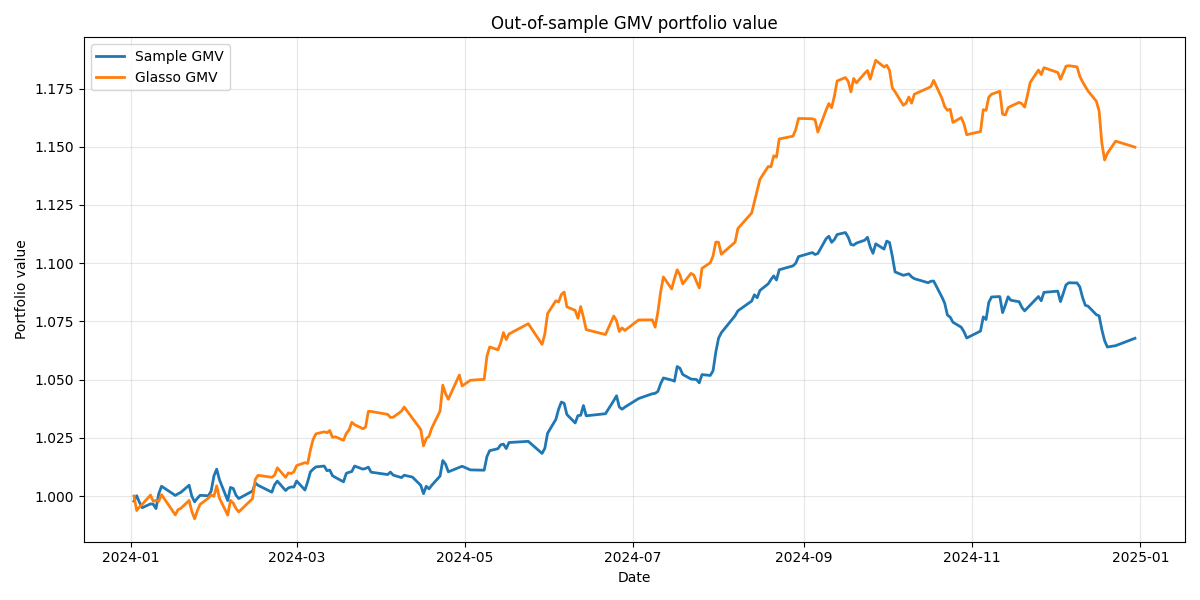

In [119]:
# Cell 9: Fixed train/test split (out-of-sample) with GMV portfolios
OOS_START_DATE = "2021-01-01"
OOS_END_DATE = "2025-01-01"
TRAIN_YEARS = 3
TEST_YEARS = 1

oos_start = pd.Timestamp(OOS_START_DATE)
oos_end = pd.Timestamp(OOS_END_DATE)
train_end = oos_start + pd.DateOffset(years=TRAIN_YEARS)
test_end = train_end + pd.DateOffset(years=TEST_YEARS)

if test_end > oos_end:
    raise ValueError(
        "Not enough data for TRAIN_YEARS + TEST_YEARS inside the date range."
    )

# Use existing returns_df if it already covers the range; otherwise download.
use_existing = "returns_df" in globals()
if use_existing:
    try:
        has_coverage = returns_df.index.min() <= oos_start and returns_df.index.max() >= test_end
        use_existing = bool(has_coverage)
    except Exception:
        use_existing = False

if use_existing:
    returns_full = returns_df.copy()
else:
    returns_full = get_data(
        TICKERS,
        OOS_START_DATE,
        OOS_END_DATE,
        min_coverage=0.95,
        fill_nan=False,
        save=False,
    )

returns_full = returns_full.loc[oos_start:oos_end].copy()

train_mask = (returns_full.index >= oos_start) & (returns_full.index < train_end)
test_mask = (returns_full.index >= train_end) & (returns_full.index < test_end)

train_returns = returns_full.loc[train_mask]
test_returns = returns_full.loc[test_mask]

if train_returns.empty or test_returns.empty:
    raise ValueError("Train/test split is empty. Check dates or data coverage.")

# Sample covariance and precision
sample_cov = train_returns.cov().values
sample_prec = np.linalg.pinv(sample_cov)

# Glasso covariance and precision
glasso_cov, glasso_prec = glasso(
    alpha=ALPHA,
    returns_df=train_returns,
    save_outputs=False,
    max_iter=200,
)

# GMV weights (use existing helper if defined)
if "min_variance_portfolio" not in globals():
    def min_variance_portfolio(Theta):
        ones = np.ones(Theta.shape[0])
        A = ones @ Theta @ ones
        if A <= 0 or not np.isfinite(A):
            raise ValueError("Invalid A = 1' Theta 1. Precision matrix may be invalid.")
        return (Theta @ ones) / A

w_sample = min_variance_portfolio(sample_prec)
w_glasso = min_variance_portfolio(glasso_prec)

w_sample = pd.Series(w_sample, index=train_returns.columns)
w_glasso = pd.Series(w_glasso, index=train_returns.columns)

# Out-of-sample portfolio values
test_returns = test_returns.loc[:, train_returns.columns]
ret_sample = test_returns.values @ w_sample.values
ret_glasso = test_returns.values @ w_glasso.values

value_sample = pd.Series((1.0 + ret_sample).cumprod(), index=test_returns.index, name="Sample")
value_glasso = pd.Series((1.0 + ret_glasso).cumprod(), index=test_returns.index, name="Glasso")

print("Train window:", train_returns.index.min().date(), "->", train_returns.index.max().date())
print("Test window :", test_returns.index.min().date(), "->", test_returns.index.max().date())
print("Final value - Sample:", value_sample.iloc[-1])
print("Final value - Glasso:", value_glasso.iloc[-1])

plt.figure(figsize=(12, 6))
plt.plot(value_sample.index, value_sample.values, label="Sample GMV", linewidth=2)
plt.plot(value_glasso.index, value_glasso.values, label="Glasso GMV", linewidth=2)
plt.title("Out-of-sample GMV portfolio value")
plt.xlabel("Date")
plt.ylabel("Portfolio value")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()
